In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [53]:
from google.colab import drive
drive.mount('/content/drive')

local_zip = '/content/drive/MyDrive/DATASETS-ML/rockpaperscissors.zip'
base_dir = '/content/drive/MyDrive/DATASETS-ML/rockpaperscissors'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import zipfile
from google.colab import drive
import os

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(base_dir)

train_dir = os.path.join(base_dir, 'rps-cv-images')

In [55]:
if os.path.exists(train_dir):
    print(f"File telah diekstrak ke: {train_dir}")
else:
    print("Gagal mengekstrak file.")

File telah diekstrak ke: /content/drive/MyDrive/DATASETS-ML/rockpaperscissors/rps-cv-images


In [60]:
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.4
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.4
)

train_set = train_datagenerator.flow_from_directory(
    train_dir,
    target_size=(100, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_set = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


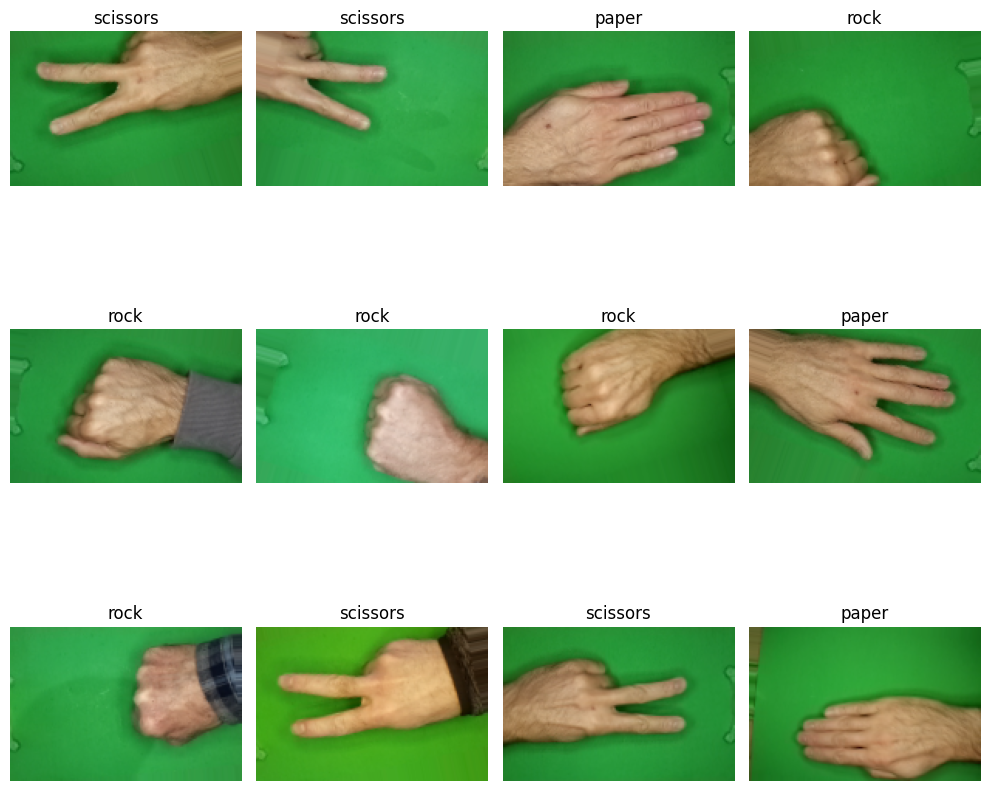

In [61]:
batch_images, batch_labels = train_set.next()
class_indices = train_set.class_indices
labels = {v: k for k, v in class_indices.items()}
labels = {v: k for k, v in class_indices.items()}
plt.figure(figsize=(10, 10))
for i in range(len(batch_images)):
    if i >= 12:
        break
    plt.subplot(3, 4, i + 1)
    plt.imshow(batch_images[i])
    plt.title(labels[np.argmax(batch_labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [66]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.000003
)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_set,
    epochs=15,
    validation_data=valid_set,
    callbacks=[learning_rate_reduction]
)

Epoch 1/15
42/42 [==============================] - 76s 2s/step - loss: 1.0298 - accuracy: 0.4513 - val_loss: 0.8355 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - 73s 2s/step - loss: 0.6662 - accuracy: 0.7572 - val_loss: 0.2832 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - 73s 2s/step - loss: 0.2953 - accuracy: 0.8935 - val_loss: 0.2000 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 4/15
42/42 [==============================] - 68s 2s/step - loss: 0.2559 - accuracy: 0.9049 - val_loss: 0.2228 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 5/15
42/42 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9376
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 [==============================] - 74s 2s/step - loss: 0.1818 - accuracy: 0.9376 - val_loss: 0.2714 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 6/15
42/42 [==============================] - 65s 2s/step - loss: 0.16

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def eval_plot(history, save_fig=False, fig_name='plot.png'):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()

    if save_fig:
        plt.savefig(fig_name)
    else:
        plt.show()

def evaluate_model(model, validation_generator, print_metrics=True):
    num_of_test_samples = len(validation_generator.filenames)
    batch_size = 32

    Y_pred = model.predict(validation_generator, steps=num_of_test_samples // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)

    y_true = validation_generator.classes

    if print_metrics:
        print('\nConfusion Matrix:\n')
        cm = confusion_matrix(y_true, y_pred)
        print(cm)

        target_names = list(validation_generator.class_indices.keys())

        print('\nClassification Report:\n')
        print(classification_report(y_true, y_pred, target_names=target_names))

    return y_true, y_pred, cm  # Return metrics for further analysis if needed


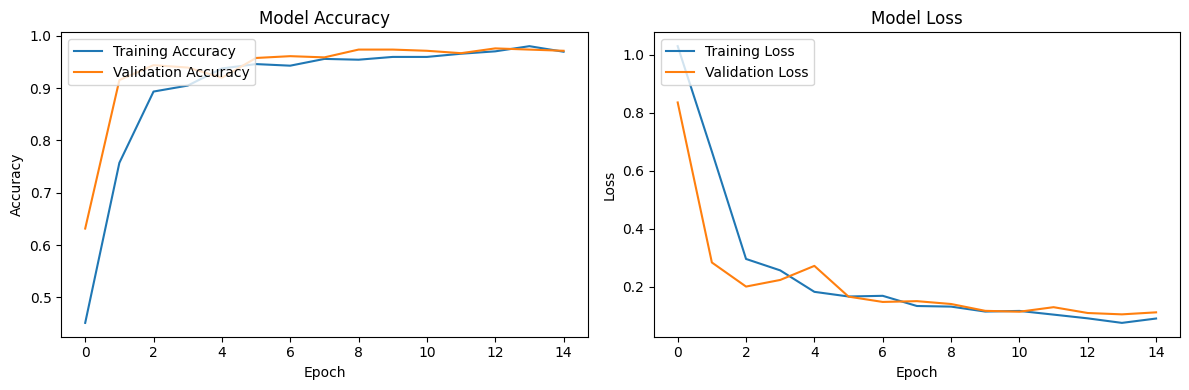

28/28 [==============================] - 12s 412ms/step

Confusion Matrix:

[[ 91  88 105]
 [ 92  98 100]
 [ 98 100 102]]

Classification Report:

              precision    recall  f1-score   support

       paper       0.32      0.32      0.32       284
        rock       0.34      0.34      0.34       290
    scissors       0.33      0.34      0.34       300

    accuracy                           0.33       874
   macro avg       0.33      0.33      0.33       874
weighted avg       0.33      0.33      0.33       874



(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [72]:
eval_plot(history)
evaluate_model(model, valid_set)


In [73]:

def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 100, 150, 3])

  predict_proba = sorted(model.predict(im_input)[0])[2]
  predict_class = np.argmax(model.predict(im_input))

  if predict_class == 0:
      predict_label = 'Paper'
  elif predict_class == 1:
      predict_label = 'Rock'
  else:
      predict_label = 'Scissor'

  print('\n')
  plt.show()
  print("\nImage prediction result: ", predict_label)
  print("Probability: ", round(predict_proba*100,2), "%")
  print('\n')

Saving 163ba5058014b2b8aada92fc10947301.jpg to 163ba5058014b2b8aada92fc10947301.jpg
1/1 [==============================] - 0s 34ms/step




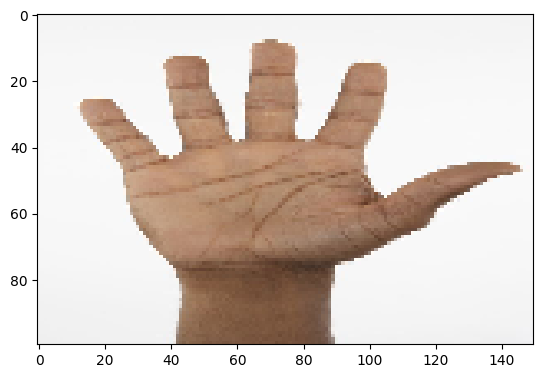


Image prediction result:  Paper
Probability:  100.0 %




In [76]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(100,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

predict_image(img)